In [1]:
import os
import code
import glob

import h5py
import numpy as np
from matplotlib import path
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm
import math

import tifffile
import roifile


def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


def filterBaseline_dFcomp(raw, pts = 99):
    F_temp = raw
    F_temp = np.concatenate((np.repeat(np.mean(F_temp[2:5]),pts),F_temp))
    F_temp = np.concatenate((F_temp, np.repeat(np.mean(F_temp[-4:-1]),pts)))
    # 25th percentile medfilt
    F_temp = signal.medfilt(F_temp, pts)
    # remove padding
    raw_new = F_temp[pts:-pts]
    #code.interact(local=dict(globals(), **locals()))
    raw_new = np.divide((raw - raw_new), raw_new)
    
    raw_newlpf = signal.medfilt(raw_new, 91)
    
    raw_new = raw_new - raw_newlpf
    
    return raw_new





In [45]:
# quickly getting dffs, pared down


chnk=1e3

parent_dir = '/home/schollab-beyonce/Documents/BRUKER/TSeries-10312024-1700-006'

os.chdir(parent_dir)
h = h5py.File('registered.h5', 'r')
datName = [key for key in h.keys()][0]
totalFrames, sizeX, sizeY = h[datName].shape

roi_list = roifile.roiread("RoiSet.zip")
numCells = len(roi_list)

x = np.linspace(0, sizeX-1, sizeX)
y = np.linspace(0, sizeY-1, sizeY)
x, y = np.meshgrid(x, y)
mask2d = np.zeros((numCells, sizeX, sizeY))
for cc in tqdm(range(numCells), desc="getting masks", ncols=75):
    nmCoord = roi_list[cc].coordinates()
    mask2d[cc,:,:] = inpolygon(x, y, nmCoord[:,0], nmCoord[:,1])
raw_cell_traces = np.zeros((totalFrames, numCells))
dff = np.zeros((totalFrames, numCells))
for f_i in tqdm(range(math.ceil(totalFrames / chnk)), desc="Extracting...", ncols=75):
    start = int(f_i * chnk)
    stop = min(int((f_i + 1) * chnk), totalFrames)
    imgstack = h[datName][start:stop, :, :]
    for cc in range(numCells):
        nz = np.nonzero(mask2d[cc,:,:])
        raw_cell_traces[start:stop, cc] = np.mean(imgstack[:,nz[0], nz[1]], axis=1)

print("Calculating dff for all cells")
for cc in range(numCells):
    dff[:,cc] = filterBaseline_dFcomp(raw_cell_traces[:,cc], 99*4+1)
print("done")
#code.interact(local=dict(globals(), **locals()))

Extracting...: 100%|█████████████████████████| 2/2 [00:00<00:00,  2.65it/s]


Calculating dff for all cells
done


In [46]:
# Saving results
np.savetxt('raw_traces.csv', raw_cell_traces, delimiter=',')
np.savetxt('dff.csv', dff, delimiter=',')

/tmp/ipykernel_11325/3524850257.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


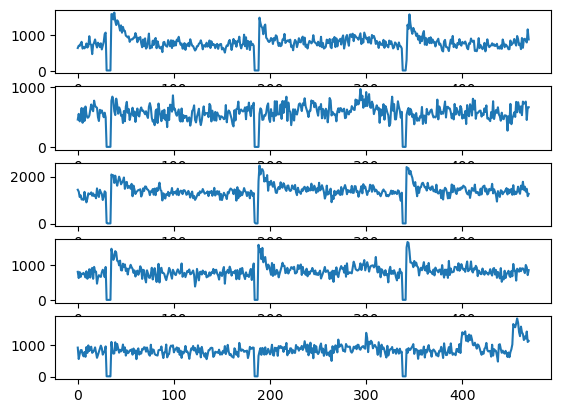

In [37]:
cells = [0, 1, 2, 3, 4]
fig, axs = plt.subplots(len(cells),1)
for i in range(len(cells)):
    axs[i].plot(raw_cell_traces[30:500,i])
    #axs[i].plot(dff[:,i])
fig.show()

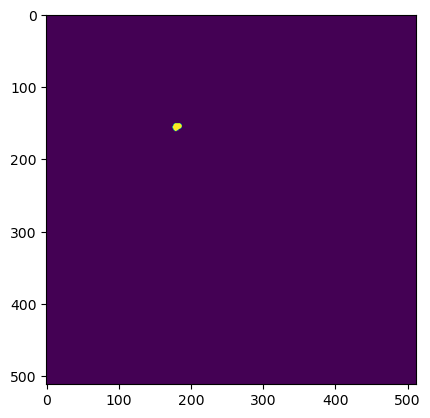

In [16]:
mask2d.shape
plt.imshow(mask2d[0,:,:])
plt.imshow(mask2d[2,:,:])
plt.imshow(mask2d[0,:,:])


/tmp/ipykernel_11325/1056805327.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


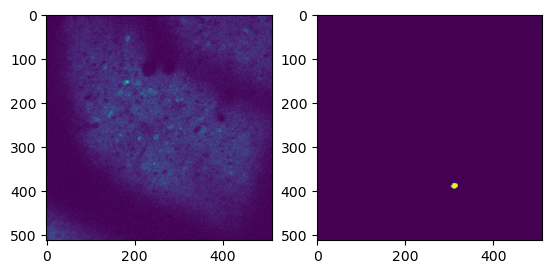

In [30]:
frame = np.mean(imgstack, axis=0)
fig, axs = plt.subplots(1,2)
axs[0].imshow(frame)
axs[1].imshow(mask2d[39,:,:])
fig.show()
